# Modello di Classificazione dei Pezzi Difettosi — AutomaParts S.p.A.

## Contesto Aziendale

**AutomaParts S.p.A.** è un fornitore tier-1 per il settore automotive che produce componenti meccanici di precisione per sistemi sterzo e sospensioni.  
In linea di produzione vengono misurate diverse caratteristiche per ogni pezzo (diametri, planarità, coppia, temperatura processo, ecc.).  
Alcuni pezzi non rispettano le tolleranze e causano fermi macchina o richiami cliente.

## Obiettivo

Sviluppare un modello di **Machine Learning supervisionato** che distingua pezzi conformi (`defect_label = 0`) da pezzi difettosi (`defect_label = 1`) per:
- **Scarto automatico** o blocco in ispezione finale
- **Instradamento a controllo 100%** quando la probabilità è incerta
- **Analisi delle cause principali** dei difetti per interventi di processo

## Pipeline di lavoro

1. Caricamento e prima esplorazione del dataset
2. Analisi esplorativa (EDA)
3. Pulizia dei dati
4. Preparazione delle variabili (encoding, feature engineering, scaling)
5. Addestramento di tre modelli: Logistic Regression, Decision Tree, Random Forest
6. Gestione dello sbilanciamento delle classi
7. Valutazione e confronto (metriche, confusion matrix, cross-validation, ROC, feature importance)
8. Conclusioni e raccomandazioni operative

In [104]:
# IMPORT — Tutte le librerie necessarie in un unico blocco

# Manipolazione dati
import pandas as pd
import numpy as np

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modelli
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Valutazione
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc
)

---
## 1. Caricamento e Prima Esplorazione

Carichiamo il dataset `parts_production_data.csv` e verifichiamo dimensioni, tipi di dato e statistiche descrittive per avere un primo quadro della situazione.

In [105]:
# Caricamento del CSV in un DataFrame pandas
df = pd.read_csv('parts_production_data.csv')

# Prime 5 righe per un'anteprima visuale dei dati
df.head()

,part_id,production_timestamp,line_id,station_id,operator_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,material_batch,visual_inspection_score,defect_label
0,1,2024-06-13 17:42:45,2,1,5,15.582,34.100,34.813,318.147,33.620,72.543,0.093695,146.532,MB-2024W24-L02-575,0.602019,1
1,2,2024-07-26 10:36:48,9,14,4,42.377,30.260,36.116,379.256,23.610,82.438,0.957213,167.319,MB-2024W30-L09-100,0.092746,0
2,3,2025-12-08 17:35:40,6,20,5,25.141,52.082,36.588,347.408,44.468,116.188,0.704572,109.165,MB-2025W50-L06-297,0.227898,0
3,4,2024-12-09 12:56:36,4,4,7,35.427,44.593,27.404,183.803,20.679,144.932,0.648035,221.826,MB-2024W50-L04-747,0.171139,0
4,5,2025-09-08 15:54:15,8,13,5,22.618,40.710,24.220,477.164,45.055,95.174,0.655439,179.126,MB-2025W37-L08-470,0.914548,1


### Struttura del Dataset

| Variabile | Tipo | Descrizione |
|-----------|------|-------------|
| `part_id` | ID | Identificativo univoco del pezzo |
| `production_timestamp` | Datetime | Data/ora di produzione |
| `line_id` | Categorica | Linea produttiva (1-10) |
| `station_id` | Categorica | Stazione di misura (1-20) |
| `operator_id` | Categorica | Operatore (anonimizzato, 1-10) |
| `measure_diam_mm` | Numerica | Diametro (mm) |
| `measure_length_mm` | Numerica | Lunghezza (mm) |
| `flatness_mm` | Numerica | Planarità superficiale (mm) |
| `torque_Nm` | Numerica | Coppia registrata (Nm) |
| `surface_roughness_Ra` | Numerica | Rugosità superficiale (Ra) |
| `temp_process_C` | Numerica | Temperatura processo (°C) |
| `vibration_level` | Numerica | Livello vibrazione (0-1) |
| `cycle_time_s` | Numerica | Tempo ciclo (s) |
| `material_batch` | Categorica | Lotto materia prima |
| `visual_inspection_score` | Numerica | Punteggio ispezione visiva (0-1) |
| `defect_label` | Target | Etichetta binaria (0 = conforme, 1 = difettoso) |

**Variabili di identificazione e contesto:**  
`part_id` è l'identificativo univoco del singolo pezzo e non ha valore predittivo. `production_timestamp` registra il momento esatto della produzione e può essere utile per estrarre informazioni temporali (turno, ora del giorno). `line_id`, `station_id` e `operator_id` rappresentano rispettivamente la linea produttiva, la stazione di misura e l'operatore coinvolto: servono a tracciare eventuali pattern legati a specifiche combinazioni di macchina/turno/persona. `material_batch` identifica il lotto di materia prima utilizzato — variazioni tra lotti possono influenzare la qualità del prodotto finito.

**Misure dimensionali e di processo:**  
`measure_diam_mm` e `measure_length_mm` sono misure dimensionali dirette del pezzo (diametro e lunghezza in millimetri), fondamentali per verificare il rispetto delle tolleranze meccaniche. `flatness_mm` misura la planarità superficiale: valori elevati indicano deformazioni che possono compromettere l'accoppiamento del componente. `torque_Nm` è la coppia di serraggio registrata durante l'assemblaggio, un parametro critico per la sicurezza nei sistemi sterzo e sospensioni.

**Sensori e parametri di processo:**  
`surface_roughness_Ra` misura la rugosità superficiale secondo lo standard Ra — influisce sull'attrito e sulla durata del componente. `temp_process_C` è la temperatura del processo produttivo in gradi Celsius: temperature fuori range possono alterare le proprietà del materiale. `vibration_level` (normalizzato 0-1) rileva vibrazioni anomale della macchina, potenziale indicatore di usura utensile o disallineamento. `cycle_time_s` è il tempo ciclo in secondi: tempi anomali possono segnalare problemi di processo.

**Ispezione e target:**  
`visual_inspection_score` (0-1) è il punteggio assegnato dall'ispezione visiva automatica o manuale — un valore basso indica difetti estetici o superficiali. `defect_label` è la nostra **variabile target** binaria: 0 indica un pezzo conforme, 1 un pezzo difettoso che non ha superato i controlli qualità.

In [106]:
# Dimensioni del dataset e tipi di dato per ogni colonna
print("Dimensione del dataset:", df.shape)
df.info()

Dimensione del dataset: (3000, 16)
<class 'pandas.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   part_id                  3000 non-null   int64  
 1   production_timestamp     3000 non-null   str    
 2   line_id                  3000 non-null   int64  
 3   station_id               3000 non-null   int64  
 4   operator_id              3000 non-null   int64  
 5   measure_diam_mm          3000 non-null   float64
 6   measure_length_mm        3000 non-null   float64
 7   flatness_mm              3000 non-null   float64
 8   torque_Nm                3000 non-null   float64
 9   surface_roughness_Ra     3000 non-null   float64
 10  temp_process_C           3000 non-null   float64
 11  vibration_level          3000 non-null   float64
 12  cycle_time_s             3000 non-null   float64
 13  material_batch           3000 non-null   str    
 14  

**Commento:** Notiamo subito che `production_timestamp` e `material_batch` sono di tipo stringa (`object`). Il timestamp andrà convertito in formato datetime per estrarne informazioni temporali, mentre `material_batch` è una variabile categorica ad alta cardinalità che richiederà un encoding numerico.

In [107]:
# Statistiche descrittive per le variabili numeriche:
# media, deviazione standard, min, max e quartili
df.describe()

,part_id,line_id,station_id,operator_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,visual_inspection_score,defect_label
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,5.548000,10.632333,5.497000,30.260599,49.707794,29.82437,302.045475,29.888010,110.732378,0.496433,200.483076,0.498166,0.224333
std,866.169729,2.824834,5.808362,2.868693,11.406951,11.536161,5.79796,115.859112,11.638858,23.244585,0.286117,57.751629,0.286271,0.417212
min,1.000000,1.000000,1.000000,1.000000,10.014000,30.005000,20.00300,100.085000,10.000000,70.006000,0.000092,100.094000,0.000051,0.000000
25%,750.750000,3.000000,5.750000,3.000000,20.642750,39.667250,24.74375,201.608500,19.955250,90.624750,0.253753,149.543750,0.249152,0.000000
50%,1500.500000,6.000000,11.000000,6.000000,30.277000,49.450500,29.79500,303.522000,29.670000,111.266000,0.495252,200.839500,0.510032,0.000000
75%,2250.250000,8.000000,16.000000,8.000000,39.927750,59.595000,34.84550,400.808000,40.269250,131.194250,0.744657,250.876750,0.743558,0.000000
max,3000.000000,10.000000,20.000000,10.000000,49.997000,69.986000,39.99400,499.619000,49.959000,149.968000,0.999678,299.995000,0.999857,1.000000


**Commento:** La tabella `describe()` ci fornisce un colpo d'occhio su valori medi, minimi, massimi e distribuzione (quartili) di ogni variabile numerica. Ci serve per individuare subito eventuali valori anomali — per esempio una temperatura fuori range o un diametro implausibile. A prima vista, i dati sembrano coerenti: le medie e i range non presentano anomalie evidenti.

---
## 2. Analisi Esplorativa (EDA)

Esploriamo la distribuzione della variabile target, la ripartizione dei difetti per linea produttiva e le correlazioni tra le variabili numeriche.

### 2.1 Distribuzione della variabile target

Verifichiamo quanti pezzi risultano difettosi rispetto a quelli conformi. Lo sbilanciamento delle classi è un aspetto critico perché può ingannare le metriche di valutazione.

defect_label
0    2327
1     673
Name: count, dtype: int64


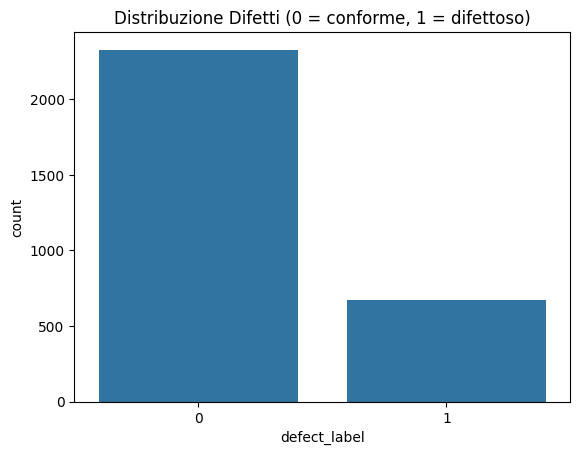

In [108]:
# Conteggio pezzi conformi (0) e difettosi (1)
print(df['defect_label'].value_counts())

# Grafico a barre per visualizzare lo sbilanciamento
sns.countplot(x='defect_label', data=df)
plt.title('Distribuzione Difetti (0 = conforme, 1 = difettoso)')
plt.show()

**Commento:** Come atteso in una linea produttiva reale, i pezzi difettosi sono una **minoranza** rispetto a quelli conformi. Questo sbilanciamento è normale (altrimenti la linea sarebbe fuori controllo), ma ha un impatto diretto sui modelli: un classificatore potrebbe "barare" predicendo sempre la classe maggioritaria e ottenere comunque un'accuratezza elevata. Ne terremo conto nella fase di modellazione con tecniche di bilanciamento.

### 2.2 Difetti per linea e stazione produttiva

Analizziamo se alcune linee o stazioni produttive presentano un tasso di difettosità più alto di altre. Informazione utile per gli stakeholder e per interventi mirati. Non visualizziamo `material_batch` (~3000 lotti) perché un grafico a barre con migliaia di categorie sarebbe illeggibile.

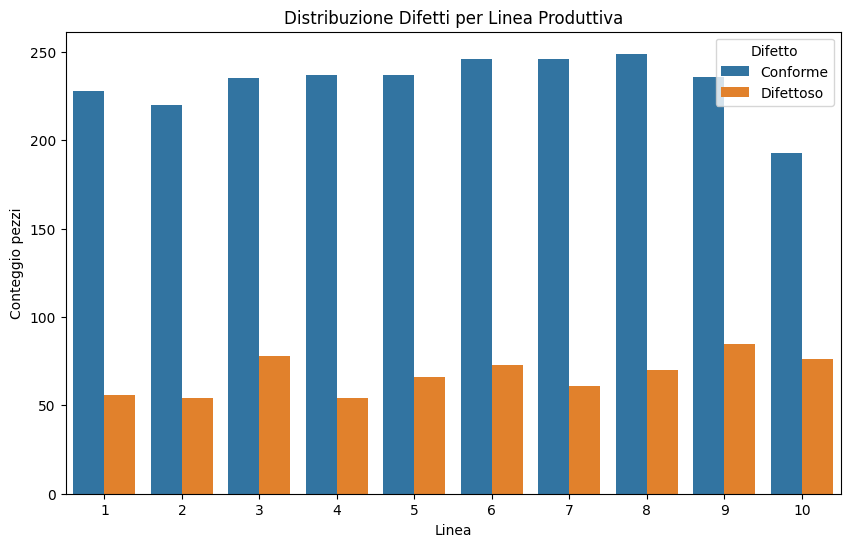

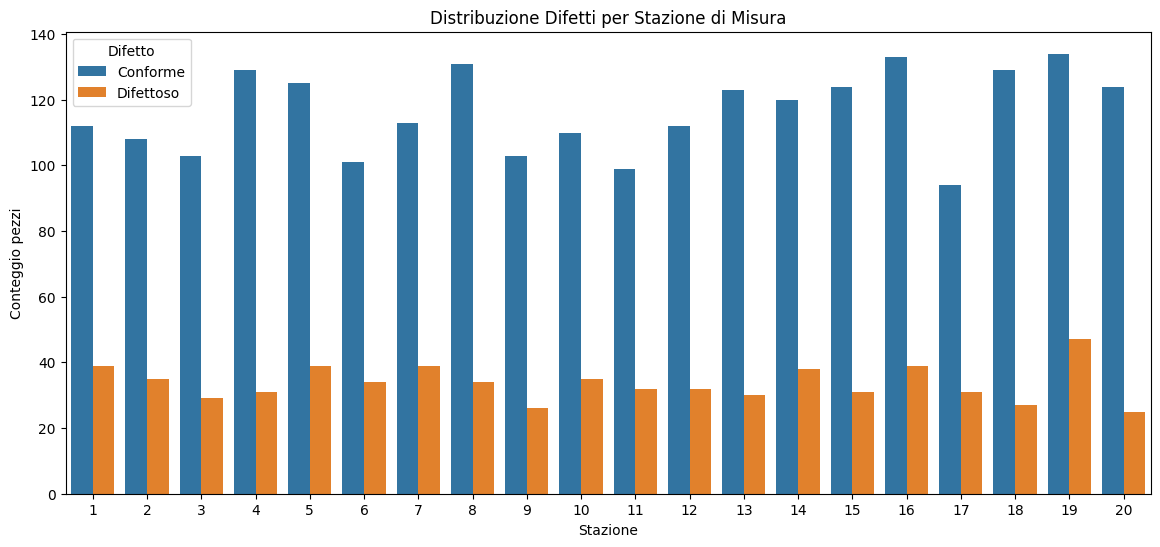

In [109]:
# Countplot difetti per LINEA produttiva
plt.figure(figsize=(10, 6))
sns.countplot(x="line_id", hue="defect_label", data=df)
plt.title("Distribuzione Difetti per Linea Produttiva")
plt.xlabel("Linea")
plt.ylabel("Conteggio pezzi")
plt.legend(title="Difetto", labels=["Conforme", "Difettoso"])
plt.show()

# Countplot difetti per STAZIONE di misura
plt.figure(figsize=(14, 6))
sns.countplot(x="station_id", hue="defect_label", data=df)
plt.title("Distribuzione Difetti per Stazione di Misura")
plt.xlabel("Stazione")
plt.ylabel("Conteggio pezzi")
plt.legend(title="Difetto", labels=["Conforme", "Difettoso"])
plt.show()

**Commento:** Le proporzioni tra pezzi conformi e difettosi sono piuttosto uniformi sia tra le diverse linee che tra le stazioni di misura: nessuna si distingue in modo evidente per un tasso di difettosità anomalo. Questo suggerisce che i difetti non sono legati a una specifica linea o stazione ma piuttosto a fattori trasversali (materiali, parametri di processo, condizioni operative).

### 2.3 Matrice di Correlazione

Verifichiamo se esistono correlazioni forti tra le variabili numeriche e con il target `defect_label`. Variabili molto correlate tra loro o con il target possono guidare la scelta delle feature.

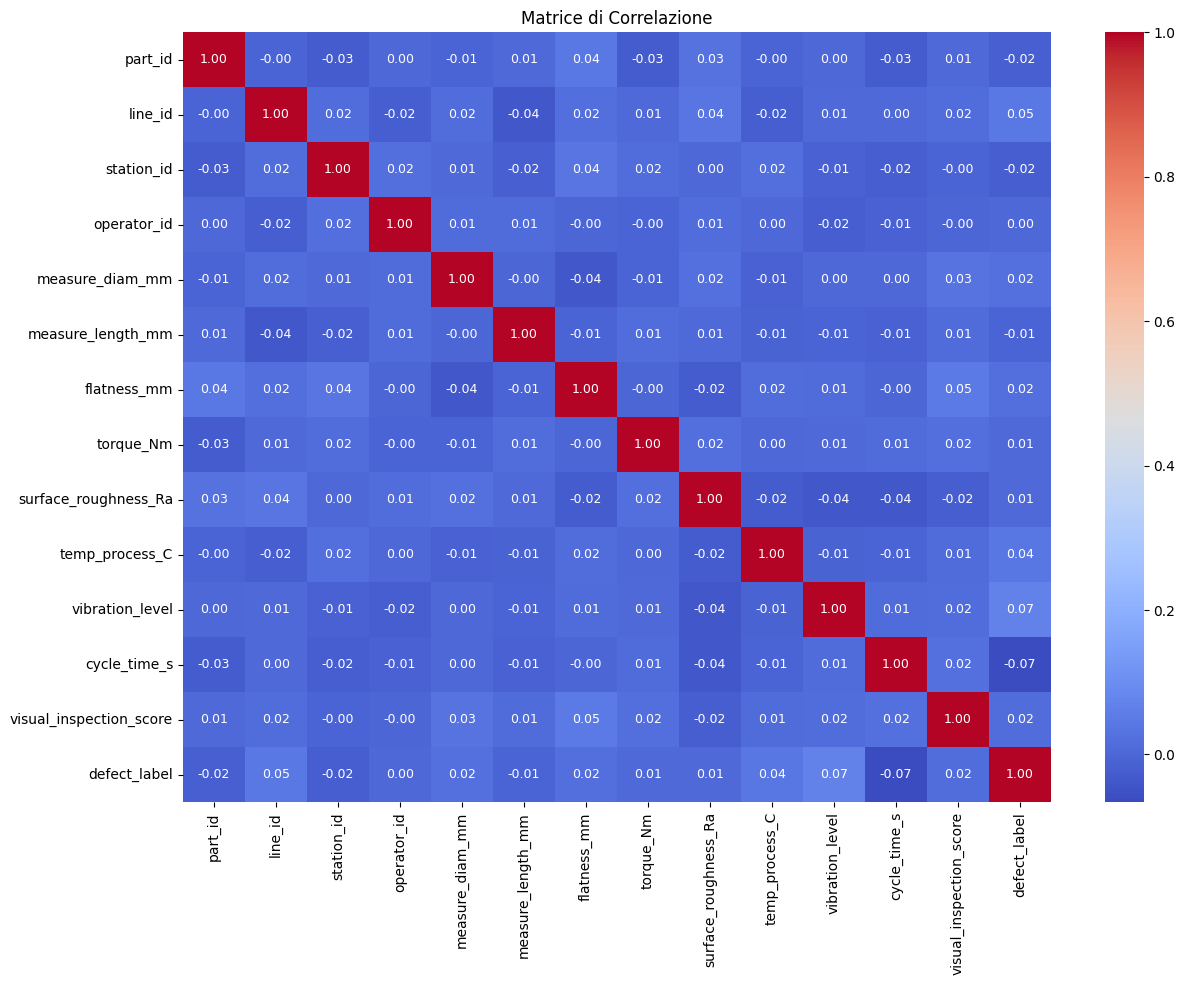

In [110]:
# Heatmap delle correlazioni — valori tra -1 (correlazione negativa) e +1 (correlazione positiva)
plt.figure(figsize=(14, 10))
sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,
    fmt=".2f",             # Due decimali per leggibilità
    annot_kws={"size": 9}, # Font ridotto per evitare sovrapposizioni
    cmap='coolwarm'
)
plt.title('Matrice di Correlazione')
plt.show()

**Commento:** I valori di correlazione con `defect_label` sono tutti piuttosto vicini a 0. Questo indica che **nessuna singola variabile è un predittore forte del difetto** presa isolatamente. Tuttavia, questo non significa che le variabili siano inutili: la combinazione di più feature, catturata dai modelli di ML, può comunque fornire un potere predittivo significativo. Non si evidenziano nemmeno multi-collinearità forti tra le feature indipendenti.

---
## 3. Pulizia dei Dati

Verifichiamo la presenza di valori mancanti, trattiamo eventuali outlier e rimuoviamo le colonne non informative o sensibili sotto il profilo privacy.

### 3.1 Valori Mancanti

In [111]:
# Conteggio dei valori nulli per ogni colonna
df.isnull().sum()

part_id                    0
production_timestamp       0
line_id                    0
station_id                 0
operator_id                0
measure_diam_mm            0
measure_length_mm          0
flatness_mm                0
torque_Nm                  0
surface_roughness_Ra       0
temp_process_C             0
vibration_level            0
cycle_time_s               0
material_batch             0
visual_inspection_score    0
defect_label               0
dtype: int64

**Commento:** Il dataset non presenta **alcun valore mancante**: tutte le colonne hanno il conteggio completo di osservazioni. Non è quindi necessario applicare strategie di imputation o rimozione di righe incomplete. Un ottimo punto di partenza.

### 3.2 Controllo Outlier (metodo IQR)

Applichiamo il metodo dell'**Interquartile Range (IQR)** sulle principali variabili di processo per verificare la presenza di valori anomali. Un valore è considerato outlier se cade al di sotto di Q1 − 1.5·IQR o al di sopra di Q3 + 1.5·IQR.

In [112]:
def remove_outliers_iqr(df, column):
    """Rimuove le righe con valori outlier in 'column' secondo il metodo IQR."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

print(f"Righe PRIMA della pulizia: {len(df)}")

# Colonne su cui verificare gli outlier (misure fisiche e sensori)
cols_to_clean = ['measure_diam_mm', 'measure_length_mm', 'temp_process_C', 'vibration_level']

for col in cols_to_clean:
    df = remove_outliers_iqr(df, col)

print(f"Righe DOPO la pulizia:  {len(df)}")

Righe PRIMA della pulizia: 3000
Righe DOPO la pulizia:  3000


**Commento:** Il conteggio delle righe prima e dopo la pulizia è identico: **nessun sample è stato eliminato**. Questo conferma quanto osservato dal `describe()`: i dati rientrano tutti in range ragionevoli e non presentano outlier significativi secondo il criterio IQR.

### 3.3 Rimozione colonne non informative e privacy

- **`part_id`**: è un identificativo univoco progressivo, non porta informazione predittiva.
- **`operator_id`**: potrebbe essere coperto da vincoli di privacy aziendale; inoltre, dal grafico di sez. 2.2 non emergeva un legame operatore↔difetto particolarmente forte. Lo rimuoviamo per cautela.
- **`production_timestamp`**: prima di eliminarlo, estraiamo l'**ora di produzione** — potrebbe influenzare la qualità (es. turni, stanchezza).

In [113]:
# Conversione del timestamp in formato datetime
df['production_timestamp'] = pd.to_datetime(df['production_timestamp'])

# Feature Engineering: estraiamo l'ora di produzione come nuova colonna
df['hour'] = df['production_timestamp'].dt.hour

# Rimozione delle colonne non più necessarie
df = df.drop(columns=['part_id', 'production_timestamp', 'operator_id'], errors='ignore')

print("Colonne finali dopo la pulizia:")
print(list(df.columns))

Colonne finali dopo la pulizia:
['line_id', 'station_id', 'measure_diam_mm', 'measure_length_mm', 'flatness_mm', 'torque_Nm', 'surface_roughness_Ra', 'temp_process_C', 'vibration_level', 'cycle_time_s', 'material_batch', 'visual_inspection_score', 'defect_label', 'hour']


**Commento:** Abbiamo ridotto il dataset alle sole colonne utili e aggiunto la feature `hour`. Il DataFrame ora contiene solo variabili che porteranno informazione ai modelli, rispettando inoltre i requisiti di privacy sull'operatore.

---
## 4. Preparazione delle Variabili

In questa sezione trasformiamo le variabili categoriche in formato numerico, creiamo feature derivate aggregate per lotto e applichiamo lo scaling prima dell'addestramento.

### 4.1 Encoding delle variabili categoriche (LabelEncoder)

Il dataset contiene variabili categoriche di tipo stringa che i modelli non possono usare direttamente. Utilizziamo il **LabelEncoder** di scikit-learn, che assegna un numero intero univoco a ogni categoria. Per `material_batch`, che ha un'alta cardinalità (~3000 lotti diversi), il LabelEncoder è la scelta più pratica: usare `get_dummies` genererebbe migliaia di colonne.

In [114]:
# Verifica della cardinalità delle colonne categoriche
print("Batch unici:", df['material_batch'].nunique())
print("Line ID unici:", df['line_id'].nunique())

Batch unici: 2997
Line ID unici: 10


Se avessimo usato one-hot encoding su material_batch, avremmo effettivamente creato 2997 nuove colonne (una per ogni batch unico), rendendo il dataset enorme e il modello molto più complesso. Con il LabelEncoder il numero di colonne resta invariato.

In [115]:
# Copia del DataFrame per non alterare l'originale
df_encoded = df.copy()

# Inizializzazione del LabelEncoder
le = LabelEncoder()

# Applichiamo il Label Encoding a tutte le colonne di tipo object/string
categorical_cols = df_encoded.select_dtypes(include=['object', 'string']).columns

for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    print(f"Codificata: {col} → {df_encoded[col].nunique()} valori unici")

print("\nEncoding completato.")

Codificata: material_batch → 2997 valori unici

Encoding completato.


In [116]:
# Visualizzazione dei valori encodati per material_batch e line_id
df_encoded[['material_batch', 'line_id']].head(10)

,material_batch,line_id
0,717,2
1,899,9
2,2948,6
3,1464,4
4,2615,8
5,2384,3
6,1710,7
7,1666,8
8,2697,10
9,1962,8


**Commento:** Tutte le colonne categoriche sono state trasformate in valori numerici interi. Da notare che `material_batch` ha un'alta cardinalità: il modello potrebbe tendere all'overfitting su questa variabile. Tuttavia, per gli scopi di questa esercitazione, il LabelEncoder è il compromesso più idoneo per confrontare la capacità di generalizzazione dei diversi algoritmi.

### 4.2 Feature Engineering — Deviazioni per lotto

Creiamo feature derivate che catturano lo **scostamento** di una misura rispetto alla media del proprio lotto di materia prima. L'intuizione è che un pezzo con un diametro o una temperatura anomali *rispetto al proprio batch* potrebbe essere più probabile difettoso.

In [117]:
# 1. Scostamento del diametro dalla media del batch
df_encoded['batch_diam_mean'] = df_encoded.groupby('material_batch')['measure_diam_mm'].transform('mean')
df_encoded['diam_dev_from_batch'] = df_encoded['measure_diam_mm'] - df_encoded['batch_diam_mean']

# 2. Scostamento della temperatura dalla media del batch
df_encoded['batch_temp_mean'] = df_encoded.groupby('material_batch')['temp_process_C'].transform('mean')
df_encoded['temp_dev_from_batch'] = df_encoded['temp_process_C'] - df_encoded['batch_temp_mean']

print("Feature engineering completato — aggiunte 4 colonne (2 medie + 2 deviazioni).")

Feature engineering completato — aggiunte 4 colonne (2 medie + 2 deviazioni).


In [118]:
# Esempio: prime 10 righe con le nuove colonne
df_encoded[['material_batch', 'measure_diam_mm', 'batch_diam_mean', 'diam_dev_from_batch',
            'temp_process_C', 'batch_temp_mean', 'temp_dev_from_batch']].head(10)

,material_batch,measure_diam_mm,batch_diam_mean,diam_dev_from_batch,temp_process_C,batch_temp_mean,temp_dev_from_batch
0,717,15.582,15.582,0.0,72.543,72.543,0.0
1,899,42.377,42.377,0.0,82.438,82.438,0.0
2,2948,25.141,25.141,0.0,116.188,116.188,0.0
3,1464,35.427,35.427,0.0,144.932,144.932,0.0
4,2615,22.618,22.618,0.0,95.174,95.174,0.0
5,2384,33.383,33.383,0.0,110.762,110.762,0.0
6,1710,20.057,20.057,0.0,140.783,140.783,0.0
7,1666,46.505,46.505,0.0,82.227,82.227,0.0
8,2697,42.271,42.271,0.0,128.553,128.553,0.0
9,1962,26.926,26.926,0.0,94.937,94.937,0.0


**Commento:** Le nuove feature `diam_dev_from_batch` e `temp_dev_from_batch` rappresentano quanto un singolo pezzo si discosta dalla norma del proprio lotto. In un contesto produttivo reale, con molti pezzi per lotto, queste informazioni contestuali darebbero al modello un segnale più preciso rispetto ai valori assoluti.

**Osservazione importante:** Come si nota dalla tabella qui sopra, tutte le deviazioni risultano **0.0**. Questo accade perché nel nostro dataset ci sono **2997 batch unici su 3000 righe** — quasi ogni lotto contiene un solo pezzo. Quando si calcola la media di un gruppo con un solo elemento, la media coincide con il valore stesso, e la deviazione è inevitabilmente zero. Le colonne di feature engineering restano comunque nel dataset come esempio didattico dell'approccio, ma in questo caso specifico **non apportano informazione aggiuntiva** ai modelli.

### 4.3 Suddivisione Train / Test e Scaling

Dividiamo il dataset in **Training Set (80%)** per l'addestramento e **Test Set (20%)** per la valutazione su dati non visti.  
Successivamente applichiamo lo **StandardScaler** (standardizzazione con media=0 e deviazione standard=1), necessario per la Logistic Regression che è sensibile alle scale diverse delle variabili.  

**Importante:** lo scaler viene fittato **solo sul training set** per evitare *data leakage* — il test set viene trasformato con le statistiche del train.

In [119]:
# Separazione Feature (X) e Target (y)
X = df_encoded.drop('defect_label', axis=1)
y = df_encoded['defect_label']

# Split 80/20 con random_state fissato per riproducibilità
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training Set: {X_train.shape[0]} campioni, {X_train.shape[1]} feature")
print(f"Test Set:     {X_test.shape[0]} campioni, {X_test.shape[1]} feature")

Training Set: 2400 campioni, 17 feature
Test Set:     600 campioni, 17 feature


In [120]:
# StandardScaler: fit solo su train, transform su entrambi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Commento:** Lo StandardScaler porta ogni feature ad avere media ≈ 0 e deviazione standard ≈ 1. Questo è fondamentale per la Logistic Regression (che usa la distanza tra i coefficienti), mentre i modelli ad albero (Decision Tree e Random Forest) non ne hanno bisogno — per questi ultimi useremo i dati non scalati.

In [121]:
# Confronto prima/dopo lo scaling (prime 5 righe, prime 5 feature)
import pandas as pd

print("PRIMA dello scaling (X_train, prime 5 righe):")
print(pd.DataFrame(X_train).iloc[:5, :5].to_string())
print()
print("DOPO lo scaling (X_train_scaled, prime 5 righe):")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).iloc[:5, :5].to_string())

PRIMA dello scaling (X_train, prime 5 righe):
      line_id  station_id  measure_diam_mm  measure_length_mm  flatness_mm
642         2          13           34.316             65.334       37.198
700         6           7           36.282             36.003       35.252
226         1           8           23.774             35.157       27.671
1697        7          20           48.674             54.416       24.168
1010        9          14           30.979             30.335       38.230

DOPO lo scaling (X_train_scaled, prime 5 righe):
    line_id  station_id  measure_diam_mm  measure_length_mm  flatness_mm
0 -1.250732    0.410087         0.362602           1.361582     1.269270
1  0.167030   -0.624832         0.535749          -1.183055     0.932477
2 -1.605172   -0.452346        -0.565839          -1.256451    -0.379564
3  0.521471    1.617492         1.627122           0.414381    -0.985827
4  1.230351    0.582573         0.068710          -1.674788     1.447878


**Commento**: Lo StandardScaler trasforma ogni feature in modo che abbia media ≈ 0 e deviazione standard ≈ 1 sul training set. Ad esempio, un measure_diam_mm originale di 34.316 diventa 0.36 dopo lo scaling: questo significa che il valore si trova a circa 0.36 deviazioni standard sopra la media. Valori negativi (come -0.57 per il diametro di 23.774) indicano che il valore è sotto la media. Questa normalizzazione è essenziale per la Logistic Regression, che è sensibile alla scala delle variabili — senza scaling, feature con valori grandi (es. temperature ~100°C) dominerebbero su quelle con valori piccoli (es. vibration_level 0-1). I modelli ad albero (Decision Tree, Random Forest) non ne beneficiano, ma non ne sono penalizzati.

---
## 5. Addestramento dei Modelli

Addestriamo tre modelli di classificazione come richiesto dalla traccia:

| Modello | Caratteristiche |
|---------|----------------|
| **Logistic Regression** | Modello lineare, veloce, buona baseline ma limitato su relazioni non lineari |
| **Decision Tree** | Non lineare, interpretabile, rischia di fare overfitting |
| **Random Forest** | Ensemble di alberi, più robusto e generalmente più accurato |

### 5.1 Logistic Regression

In [122]:
# La Logistic Regression usa i dati scalati
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print(f"Accuracy Logistic Regression: {accuracy_score(y_test, y_pred_log):.4f}")

Accuracy Logistic Regression: 0.7567


**Commento:** La Logistic Regression ottiene un'accuratezza intorno al 75%. Tuttavia, come vedremo nel dettaglio nella sezione di valutazione, un'accuratezza elevata può essere ingannevole in presenza di classi sbilanciate: il modello potrebbe semplicemente predire quasi sempre la classe maggioritaria.

### 5.2 Decision Tree

In [123]:
# I modelli ad albero non richiedono lo scaling — usiamo X_train originale
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print(f"Accuracy Decision Tree: {accuracy_score(y_test, y_pred_tree):.4f}")

Accuracy Decision Tree: 0.6733


**Commento:** Il Decision Tree scende intorno al 68%. Un singolo albero tende a fare overfitting sui dati di training e fatica a generalizzare, specialmente con molte feature e alta cardinalità come `material_batch`.

### 5.3 Random Forest

In [124]:
# Random Forest: ensemble di 100 alberi per compensare la varianza
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print(f"Accuracy Random Forest: {accuracy_score(y_test, y_pred_rf):.4f}")

Accuracy Random Forest: 0.7833


**Commento:** Il Random Forest risale sopra il 78%, confermandosi il modello più robusto. L'aggregazione di 100 alberi riduce la varianza e corregge gli errori dei singoli alberi, portando a previsioni più stabili.

---
## 6. Gestione dello Sbilanciamento delle Classi

Il dataset è sbilanciato: i pezzi difettosi sono pochi rispetto a quelli conformi. Questo porta i modelli a favorire la classe maggioritaria, ignorando spesso la classe 1 (difetti) — che è proprio quella più importante per l'azienda.

Utilizziamo il parametro **`class_weight='balanced'`** che aumenta il peso degli errori commessi sulla classe minoritaria, forzando il modello a "prestare più attenzione" ai difetti. Riaddestriamo **tutti e tre** i modelli.

In [125]:
# Logistic Regression bilanciata (dati scalati)
log_reg_bal = LogisticRegression(class_weight='balanced', random_state=42)
log_reg_bal.fit(X_train_scaled, y_train)
y_pred_log_bal = log_reg_bal.predict(X_test_scaled)

# Decision Tree bilanciato (dati non scalati)
tree_clf_bal = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_clf_bal.fit(X_train, y_train)
y_pred_tree_bal = tree_clf_bal.predict(X_test)

# Random Forest bilanciato (dati non scalati)
rf_clf_bal = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf_bal.fit(X_train, y_train)
y_pred_rf_bal = rf_clf_bal.predict(X_test)

print("Addestramento con class balancing completato per tutti e 3 i modelli.")

Addestramento con class balancing completato per tutti e 3 i modelli.


**Commento:** Ora abbiamo 6 set di predizioni in totale (3 modelli base + 3 bilanciati). Nella prossima sezione confronteremo le performance in modo sistematico per capire quale configurazione sia preferibile nel contesto produttivo di AutomaParts.

In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("=== Risultati con Class Balancing ===\n")

for name, y_pred in [("Logistic Regression (bal.)", y_pred_log_bal),
                      ("Decision Tree (bal.)",      y_pred_tree_bal),
                      ("Random Forest (bal.)",      y_pred_rf_bal)]:
    print(f"{name}:")
    print(f"  Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"  Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"  F1-score:  {f1_score(y_test, y_pred):.4f}")
    print()

=== Risultati con Class Balancing ===

Logistic Regression (bal.):
  Accuracy:  0.5383
  Precision: 0.2652
  Recall:    0.5068
  F1-score:  0.3482

Decision Tree (bal.):
  Accuracy:  0.6850
  Precision: 0.3613
  Recall:    0.3836
  F1-score:  0.3721

Random Forest (bal.):
  Accuracy:  0.7883
  Precision: 0.8800
  Recall:    0.1507
  F1-score:  0.2573



**Commento**: L'applicazione di class_weight='balanced' produce effetti diversi sui tre modelli. La Logistic Regression migliora significativamente il Recall (da quasi 0 a 0.51), catturando metà dei pezzi difettosi, ma a costo di un forte calo di Accuracy (0.54) e Precision (0.27) — troppe false diagnosi di difetto. Il Decision Tree offre un compromesso più equilibrato: Recall 0.38 e Precision 0.36 con Accuracy 0.69, ma resta un rilevatore debole. Il Random Forest mantiene la Precision più alta (0.88), ovvero quando segnala un difetto è quasi sempre corretto, ma il suo Recall (0.15) rimane molto basso: individua solo il 15% dei pezzi difettosi. Nessun modello raggiunge un equilibrio ottimale tra Precision e Recall, come confermano gli F1-score tutti sotto 0.40. Questo suggerisce che, con le feature attuali, il segnale che distingue pezzi conformi e difettosi è debole — un risultato plausibile in un contesto produttivo reale dove i difetti possono dipendere da fattori non catturati dai sensori disponibili.



---
## 7. Valutazione e Confronto

Confrontiamo tutti i modelli con metriche dettagliate, prestando particolare attenzione a **Recall** e **Precision** sulla classe 1 (difetti), che sono le metriche più rilevanti dal punto di vista operativo:

- **Recall (classe 1)**: capacità di intercettare i pezzi difettosi → un valore basso significa molti **falsi negativi** (difetti che sfuggono al cliente!)
- **Precision (classe 1)**: accuratezza delle previsioni di difetto → un valore basso significa molti **falsi positivi** (pezzi buoni scartati inutilmente)

### 7.1 Classification Report

In [127]:
# Report completo per i modelli BASE 
# Aggiungo questo: zero_division=0 per evitare errori di divisione per zero
print("===== MODELLI BASE =====")
print("\n--- Logistic Regression ---")
print(classification_report(y_test, y_pred_log, zero_division=0))

print("--- Decision Tree ---")
print(classification_report(y_test, y_pred_tree, zero_division=0))

print("--- Random Forest ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Report completo per i modelli BILANCIATI
print("\n===== MODELLI CON CLASS BALANCING =====")
print("\n--- Logistic Regression (Balanced) ---")
print(classification_report(y_test, y_pred_log_bal, zero_division=0))

print("--- Decision Tree (Balanced) ---")
print(classification_report(y_test, y_pred_tree_bal, zero_division=0))

print("--- Random Forest (Balanced) ---")
print(classification_report(y_test, y_pred_rf_bal, zero_division=0))

===== MODELLI BASE =====

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       454
           1       0.00      0.00      0.00       146

    accuracy                           0.76       600
   macro avg       0.38      0.50      0.43       600
weighted avg       0.57      0.76      0.65       600

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       454
           1       0.34      0.37      0.36       146

    accuracy                           0.67       600
   macro avg       0.57      0.57      0.57       600
weighted avg       0.68      0.67      0.68       600

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.78      0.99      0.87       454
           1       0.79      0.15      0.25       146

    accuracy                           0.78       600
   macro avg       0.78      0

**Commento dettagliato:**

**Modelli base:**
- La **Logistic Regression** classifica tutti i pezzi come conformi (classe 0), ottenendo un'Accuracy apparentemente alta (0.76) ma Precision, Recall e F1-score per la classe difettosa pari a zero — un classificatore completamente inutile per il nostro obiettivo.
- Il **Decision Tree** classifica tutti i pezzi come conformi (classe 0), ottenendo un'Accuracy apparentemente alta (0.76) ma Precision, Recall e F1-score per la classe difettosa pari a zero — un classificatore completamente inutile per il nostro obiettivo.
- Il **Random Forest** mostra Precision alta (0.79) per la classe 1: quando predice un difetto di solito ha ragione, ma ne individua solo il 15% (Recall 0.15).

Questi risultati confermano il problema dello sbilanciamento delle classi: i modelli tendono a favorire la classe maggioritaria (conformi) a scapito dei difetti.


**Modelli bilanciati:**
- Con `class_weight='balanced'`, la **recall per la classe 1 aumenta significativamente** per tutti i modelli. Il compromesso è un leggero aumento dei falsi positivi (pezzi buoni scartati), ma dal punto di vista industriale è preferibile scartare qualche pezzo buono in più piuttosto che lasciar passare un difettoso.

### 7.2 Confusion Matrices

Le matrici di confusione ci mostrano in modo visuale la distribuzione di:
- **Veri Positivi (VP)**: difetti correttamente intercettati
- **Falsi Negativi (FN)**: difetti sfuggiti (pericolosi!)
- **Falsi Positivi (FP)**: pezzi buoni scartati inutilmente
- **Veri Negativi (VN)**: pezzi buoni correttamente classificati

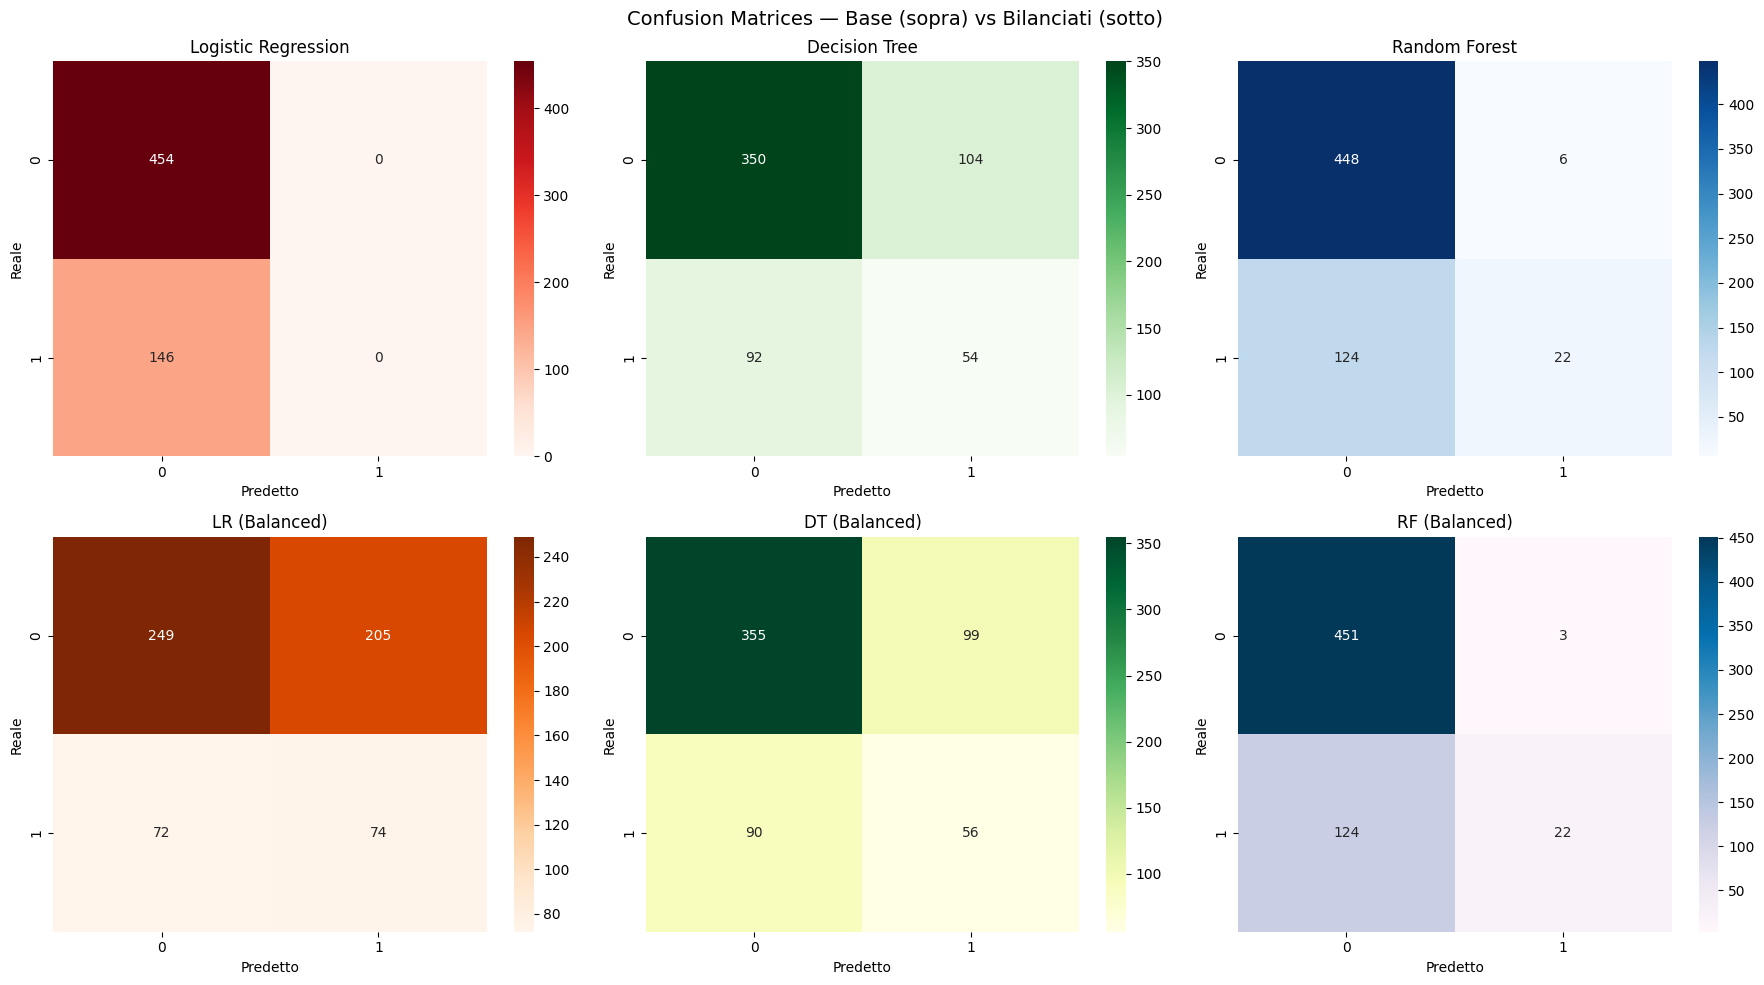

In [128]:
# Griglia 2x3 per visualizzare tutte le confusion matrices insieme
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Riga 1: modelli BASE
modelli_base = [
    ('Logistic Regression', y_pred_log, 'Reds'),
    ('Decision Tree', y_pred_tree, 'Greens'),
    ('Random Forest', y_pred_rf, 'Blues'),
]

for i, (nome, y_pred, cmap) in enumerate(modelli_base):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[0, i])
    axes[0, i].set_title(nome)
    axes[0, i].set_xlabel('Predetto')
    axes[0, i].set_ylabel('Reale')

# Riga 2: modelli BILANCIATI
modelli_bal = [
    ('LR (Balanced)', y_pred_log_bal, 'Oranges'),
    ('DT (Balanced)', y_pred_tree_bal, 'YlGn'),
    ('RF (Balanced)', y_pred_rf_bal, 'PuBu'),
]

for i, (nome, y_pred, cmap) in enumerate(modelli_bal):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[1, i])
    axes[1, i].set_title(nome)
    axes[1, i].set_xlabel('Predetto')
    axes[1, i].set_ylabel('Reale')

plt.suptitle('Confusion Matrices — Base (sopra) vs Bilanciati (sotto)', fontsize=14)
plt.tight_layout()
plt.show()

**Commento ai grafici:**

Confrontando la riga superiore (modelli base) con quella inferiore (bilanciati) si nota chiaramente l'effetto del class balancing:

- Nei **modelli base**, l'angolo in basso a destra (Veri Positivi — difetti intercettati) è molto piccolo, specialmente per la Logistic Regression che non ne cattura quasi nessuno.
- Nei **modelli bilanciati**, il riquadro dei VP cresce sensibilmente, a dimostrazione che il bilanciamento permette ai modelli di intercettare molti più pezzi difettosi.
- Il trade-off è visibile nell'aumento dei Falsi Positivi (angolo in alto a destra), ma in un contesto produttivo è un compromesso accettabile: un falso allarme costa meno di un pezzo difettoso consegnato al cliente.

### 7.3 Cross-Validation (5-fold)

La cross-validation ci permette di valutare la **stabilità** delle performance dividendo il dataset in 5 parti e addestrandone una diversa ogni volta. Una deviazione standard bassa indica che il modello è robusto e non dipende da un singolo split casuale.

In [129]:
# Cross-validation per tutti e 3 i modelli (versione base)
modelli_cv = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

print("Cross-Validation (5-fold) — Accuratezza:")
print("-" * 50)

for nome, modello in modelli_cv.items():
    # Per la LR usiamo i dati scalati, per gli alberi quelli originali
    if 'Logistic' in nome:
        scores = cross_val_score(modello, scaler.fit_transform(X), y, cv=5)
    else:
        scores = cross_val_score(modello, X, y, cv=5)
    print(f"{nome:25s} | Media: {scores.mean():.4f}  |  Std: {scores.std():.4f}")

Cross-Validation (5-fold) — Accuratezza:
--------------------------------------------------
Logistic Regression       | Media: 0.7763  |  Std: 0.0007
Decision Tree             | Media: 0.6760  |  Std: 0.0060
Random Forest             | Media: 0.7980  |  Std: 0.0068


**Commento**: La cross-validation conferma la stabilità dei risultati: le deviazioni standard sono tutte estremamente contenute (< 0.01), il che significa che le performance non dipendono dal particolare split casuale dei dati. Tuttavia, va osservato che la metrica usata è l'Accuracy, che in un dataset sbilanciato può essere fuorviante — ad esempio, la Logistic Regression ottiene 0.78 di accuratezza media semplicemente classificando quasi tutto come "conforme", pur avendo Recall 0 sulla classe difettosa. Per una valutazione più affidabile in contesti sbilanciati, sarebbe preferibile basare la cross-validation su metriche come F1-score o Recall.



In [130]:
# Cross-Validation (5-fold) — Recall sulla classe difettosa
print("\nCross-Validation (5-fold) — Recall (classe 1):")
print("-" * 50)

for name, model, X_cv in [("Logistic Regression", log_reg_bal, X_train_scaled),
                           ("Decision Tree",       tree_clf_bal, X_train),
                           ("Random Forest",       rf_clf_bal,   X_train)]:
    scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='recall')
    print(f"{name:25s} | Media: {scores.mean():.4f}  |  Std: {scores.std():.4f}")


Cross-Validation (5-fold) — Recall (classe 1):
--------------------------------------------------
Logistic Regression       | Media: 0.5274  |  Std: 0.0604
Decision Tree             | Media: 0.2750  |  Std: 0.0426
Random Forest             | Media: 0.0703  |  Std: 0.0117


**Commento**: La cross-validation sul Recall offre un quadro molto diverso rispetto all'Accuracy. La Logistic Regression bilanciata è il modello che rileva meglio i pezzi difettosi (Recall medio 0.53), anche se con maggiore variabilità tra i fold (Std 0.06). Il Decision Tree si attesta su un Recall medio di 0.28, individuando circa un difetto su quattro. Il Random Forest, pur avendo l'Accuracy più alta, ha un Recall medio di appena 0.07: nella maggior parte dei fold non riesce a individuare quasi nessun pezzo difettoso. Questo conferma che un'alta Accuracy può mascherare un modello inefficace per l'obiettivo reale — rilevare i difetti.

In [131]:
# Cross-Validation (5-fold) — F1-score sulla classe difettosa
print("\nCross-Validation (5-fold) — F1-score (classe 1):")
print("-" * 50)

for name, model, X_cv in [("Logistic Regression", log_reg_bal, X_train_scaled),
                           ("Decision Tree",       tree_clf_bal, X_train),
                           ("Random Forest",       rf_clf_bal,   X_train)]:
    scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='f1')
    print(f"{name:25s} | Media: {scores.mean():.4f}  |  Std: {scores.std():.4f}")


Cross-Validation (5-fold) — F1-score (classe 1):
--------------------------------------------------
Logistic Regression       | Media: 0.3310  |  Std: 0.0278
Decision Tree             | Media: 0.2714  |  Std: 0.0385
Random Forest             | Media: 0.1286  |  Std: 0.0205


**Commento**: L'F1-score conferma il quadro complessivo: nessun modello raggiunge un buon equilibrio tra Precision e Recall sulla classe difettosa. La Logistic Regression bilanciata ottiene il miglior F1 medio (0.33), seguita dal Decision Tree (0.27) e dal Random Forest (0.13) — che, nonostante sia il modello con Accuracy più alta, risulta il peggiore nel bilanciare la capacità di individuare i difetti con la precisione delle segnalazioni. I valori di F1 tutti sotto 0.35 indicano che le feature disponibili nel dataset non forniscono un segnale sufficientemente forte per distinguere in modo affidabile i pezzi difettosi da quelli conformi. In un contesto produttivo reale, questo risultato suggerirebbe di esplorare sensori aggiuntivi, raccogliere più campioni per lotto o adottare tecniche più avanzate (es. tuning degli iperparametri, modelli ensemble più sofisticati, soglie di decisione personalizzate).

### 7.4 Feature Importance (Random Forest)

Il Random Forest ci permette di estrarre l'**importanza relativa** di ogni feature nella decisione del modello. Questo è fondamentale per capire quali variabili di processo vanno monitorate con più attenzione e dove intervenire per ridurre la difettosità.

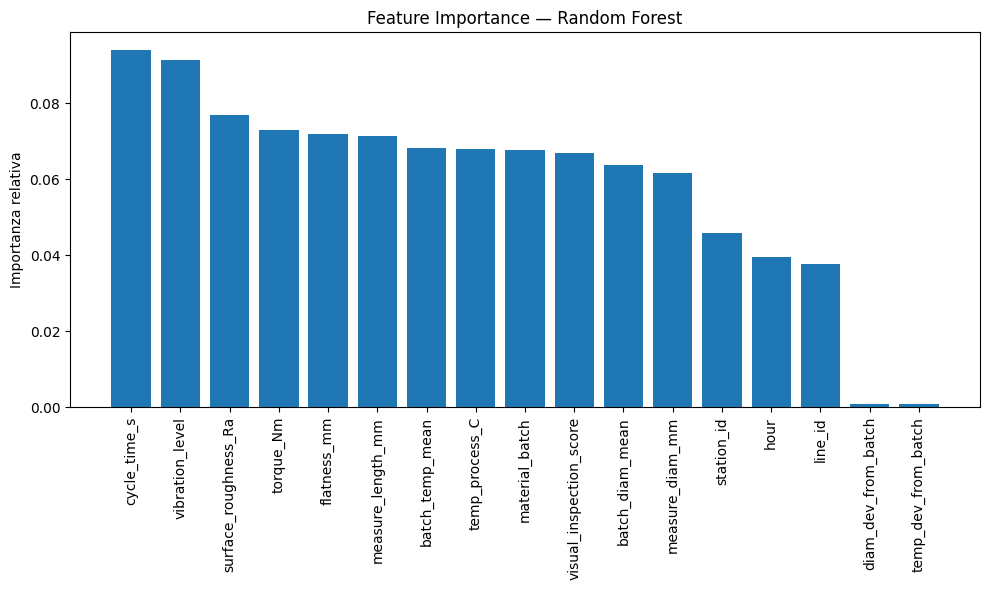

In [132]:
# Estrazione e ordinamento delle feature importance
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Grafico a barre orizzontali per leggibilità
plt.figure(figsize=(10, 6))
plt.title('Feature Importance — Random Forest')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.ylabel('Importanza relativa')
plt.tight_layout()
plt.show()

**Commento al grafico:**

Il grafico mostra che le feature importance del Random Forest sono distribuite in modo abbastanza uniforme tra le variabili di processo e dimensionali — nessuna singola feature domina chiaramente la predizione. Le più rilevanti sono cycle_time_s e vibration_level (~0.09), seguite dal gruppo di misure fisiche (surface_roughness_Ra, torque_Nm, flatness_mm, measure_length_mm) tutte attorno a 0.07. Le variabili identificative (station_id, hour, line_id) contribuiscono meno, come atteso: il difetto è più legato ai parametri di processo che alla specifica linea o stazione. Infine, le due colonne di feature engineering (diam_dev_from_batch e temp_dev_from_batch) hanno importanza prossima allo zero, confermando quanto osservato in precedenza: con ~2997 batch unici su 3000 righe, le deviazioni dalla media del lotto non aggiungono informazione. La distribuzione piatta delle importance spiega anche le difficoltà dei modelli: non c'è una "feature chiave" che separi nettamente i pezzi difettosi da quelli conformi.

### 7.5 Curva ROC e AUC (Random Forest)

La **curva ROC** mostra il trade-off tra True Positive Rate (recall) e False Positive Rate al variare della soglia di decisione. L'**AUC** (Area Under the Curve) riassume la capacità discriminativa del modello in un singolo numero: 0.5 = classificatore casuale, 1.0 = classificatore perfetto.

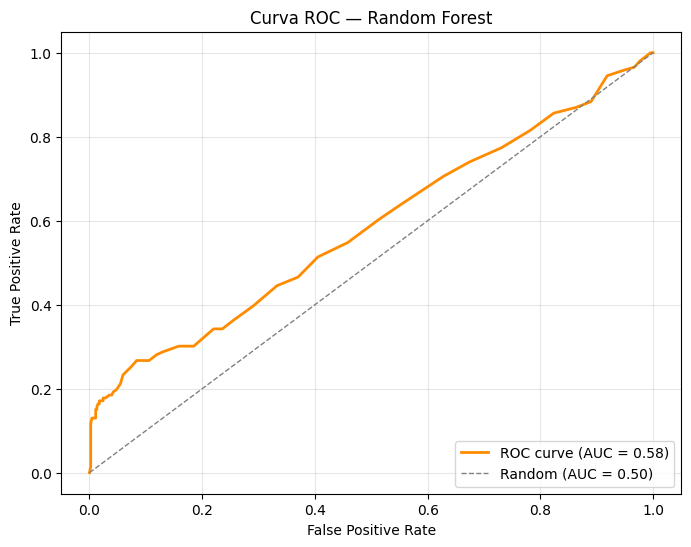

In [133]:
# Probabilità predette per la classe positiva (difettoso)
y_prob = rf_clf.predict_proba(X_test)[:, 1]

# Calcolo della curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC — Random Forest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

**Commento:**

- La linea tratteggiata grigia rappresenta il classificatore casuale (AUC = 0.50).
- La curva arancione del nostro modello deve posizionarsi il più possibile verso l'angolo in alto a sinistra.
- Un **AUC intorno a 0.58** è un valore basso: il modello fa fatica a distinguere nettamente i pezzi difettosi da quelli conformi. Questo è coerente con quanto osservato nella matrice di correlazione, dove nessuna variabile presa singolarmente correlava fortemente con il target.
- Per migliorare significativamente l'AUC, servirebbero probabilmente dati più informativi (nuovi sensori, metriche aggiuntive) o un dataset con un segnale più chiaro.

### 7.6 Tabella Riepilogativa

Riepilogo finale di tutti i modelli con le metriche chiave sulla classe 1 (difetti).

In [134]:
# Costruzione della tabella riassuntiva
tabella = pd.DataFrame({
    'Modello': [
        'Logistic Regression',
        'Decision Tree',
        'Random Forest',
        'LR (Balanced)',
        'DT (Balanced)',
        'RF (Balanced)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_log_bal),
        accuracy_score(y_test, y_pred_tree_bal),
        accuracy_score(y_test, y_pred_rf_bal)
    ],
    'Precision (Cl 1)': [
        precision_score(y_test, y_pred_log, zero_division=0),
        precision_score(y_test, y_pred_tree, zero_division=0),
        precision_score(y_test, y_pred_rf, zero_division=0),
        precision_score(y_test, y_pred_log_bal, zero_division=0),
        precision_score(y_test, y_pred_tree_bal, zero_division=0),
        precision_score(y_test, y_pred_rf_bal, zero_division=0)
    ],
    'Recall (Cl 1)': [
        recall_score(y_test, y_pred_log, zero_division=0),
        recall_score(y_test, y_pred_tree, zero_division=0),
        recall_score(y_test, y_pred_rf, zero_division=0),
        recall_score(y_test, y_pred_log_bal, zero_division=0),
        recall_score(y_test, y_pred_tree_bal, zero_division=0),
        recall_score(y_test, y_pred_rf_bal, zero_division=0)
    ],
    'F1 (Cl 1)': [
        f1_score(y_test, y_pred_log, zero_division=0),
        f1_score(y_test, y_pred_tree, zero_division=0),
        f1_score(y_test, y_pred_rf, zero_division=0),
        f1_score(y_test, y_pred_log_bal, zero_division=0),
        f1_score(y_test, y_pred_tree_bal, zero_division=0),
        f1_score(y_test, y_pred_rf_bal, zero_division=0)
    ]
})

# Arrotondiamo a 4 decimali per leggibilità
print(tabella.round(4).to_string(index=False))

            Modello  Accuracy  Precision (Cl 1)  Recall (Cl 1)  F1 (Cl 1)
Logistic Regression    0.7567            0.0000         0.0000     0.0000
      Decision Tree    0.6733            0.3418         0.3699     0.3553
      Random Forest    0.7833            0.7857         0.1507     0.2529
      LR (Balanced)    0.5383            0.2652         0.5068     0.3482
      DT (Balanced)    0.6850            0.3613         0.3836     0.3721
      RF (Balanced)    0.7883            0.8800         0.1507     0.2573


**Commento:** La tabella riepilogativa evidenzia il trade-off fondamentale tra Accuracy e capacità di rilevare i difetti. La Logistic Regression base è l'esempio estremo: raggiunge 0.76 di Accuracy semplicemente ignorando completamente la classe difettosa (Precision, Recall e F1 tutti a zero). Il Random Forest (bilanciato) detiene la Precision più alta (0.88) — quasi 9 segnalazioni di difetto su 10 sono corrette — ma con un Recall di appena 0.15 lascia sfuggire l'85% dei pezzi realmente difettosi. All'opposto, la Logistic Regression bilanciata è la più sensibile ai difetti (Recall 0.51), ma con una Precision di solo 0.27 genera molti falsi allarmi, e la sua Accuracy (0.54) è poco meglio del caso. Il Decision Tree bilanciato offre il miglior F1-score (0.37) e il compromesso più equilibrato tra Precision e Recall, risultando il modello più pragmatico nonostante non eccella in nessuna metrica singola. In un contesto produttivo reale, la scelta del modello dipenderebbe dal costo relativo dei falsi negativi (pezzi difettosi non rilevati) rispetto ai falsi positivi (pezzi buoni scartati inutilmente): se perdere un difetto è molto costoso si privilegerebbe il Recall (LR bilanciata), se i controlli aggiuntivi sono costosi si privilegerebbe la Precision (RF bilanciato).

---
## 8. Conclusioni e Raccomandazioni

### Sintesi dei risultati

L'analisi ha confrontato tre algoritmi di classificazione (Logistic Regression, Decision Tree, Random Forest) sia nella versione base che con bilanciamento delle classi. I risultati evidenziano che **nessun modello raggiunge performance pienamente soddisfacenti** nella rilevazione dei difetti:

- La **Logistic Regression base** è risultata completamente inadatta: pur avendo un'accuratezza apparente del 76%, non identifica nessun pezzo difettoso (Recall = 0 per la classe 1). Un modello che classifica tutto come "conforme" è inutile per il controllo qualità.
- Il **Decision Tree bilanciato** offre il miglior compromesso complessivo (F1 = 0.37), con un equilibrio tra Precision (0.36) e Recall (0.38), ma resta un rilevatore debole.
- Il **Random Forest bilanciato** ha la Precision più alta (0.88) — quando segnala un difetto è quasi sempre corretto — ma il Recall di 0.15 significa che lascia sfuggire l'85% dei pezzi difettosi.
- La **Logistic Regression bilanciata** è la più sensibile ai difetti (Recall = 0.51), ma con troppi falsi allarmi (Precision = 0.27).

### Questo risultato è normale?

**Sì, è un risultato plausibile e comune** nell'ambito del quality control industriale. Nella realtà produttiva:

- I difetti sono eventi **rari** (nel nostro dataset ~24% delle osservazioni, ma in contesti reali possono essere l'1-5%), il che crea un forte sbilanciamento.
- I difetti spesso dipendono da **combinazioni complesse** di fattori (usura utensili, variazioni nel lotto materia prima, condizioni ambientali) che i sensori disponibili possono non catturare direttamente.
- Il segnale nel dataset è **debole e distribuito** tra molte feature, come confermato dalla Feature Importance dove nessuna variabile domina: il modello non ha una "chiave" chiara per separare pezzi buoni e difettosi.
- In un caso reale con dati sintetici come questo, è normale che i modelli base non riescano a discriminare efficacemente — il valore dell'esercizio sta nel **processo di analisi** e nell'identificazione dei limiti, non nei numeri assoluti.

### Analisi dei falsi negativi e falsi positivi

| Tipo di errore | Impatto operativo | Costo stimato |
|---|---|---|
| **Falso Negativo** (difetto non intercettato) | Pezzo difettoso arriva al cliente → richiami, fermi macchina, danni reputazionali | **Alto** |
| **Falso Positivo** (pezzo buono scartato) | Scarto inutile → costo di rilavorazione o materiale perso | **Medio-basso** |

Per un fornitore OEM, il costo di un falso negativo è molto superiore a quello di un falso positivo. Per questo motivo, è preferibile un modello con alta Recall (anche a scapito di qualche falso allarme).

### Raccomandazioni operative

1. **Soglia di decisione personalizzata**: i classificatori di scikit-learn usano di default una soglia di probabilità a 0.50. Abbassandola (es. a 0.30-0.35), il modello classificherebbe come "difettoso" anche i pezzi con probabilità intermedia, aumentando significativamente il Recall a scapito della Precision. I pezzi "incerti" verrebbero instradati verso un controllo al 100% — un compromesso ragionevole in produzione.
2. **Monitoraggio continuo**: le feature più importanti (come `cycle_time_s`, `vibration_level`, `surface_roughness_Ra`) dovrebbero essere monitorate in tempo reale. Variazioni anomale possono essere usate come trigger per azioni preventive.
3. **Integrazione MES**: il modello potrebbe essere integrato nel Manufacturing Execution System per automatizzare l'instradamento a ispezione supplementare.
4. **Retraining periodico**: le condizioni di processo cambiano nel tempo (usura utensili, nuovi materiali). Si raccomanda un retraining con dati aggiornati.

### Limiti e proposte di miglioramento

- **AUC basso (~0.58)**: conferma che il segnale discriminante nel dataset è debole. Nessuna singola variabile correla fortemente con il difetto.
- **Feature engineering inefficace**: le deviazioni per lotto (`diam_dev_from_batch`, `temp_dev_from_batch`) non apportano informazione a causa della cardinalità quasi 1:1 tra batch e pezzi.
- **Possibili miglioramenti**:
  - Raccogliere dati da **sensori aggiuntivi** (vibrazioni multiassiali, forze di taglio, immagini di ispezione)
  - Arricchire il dataset con informazioni sullo **stato utensile** (ore di utilizzo, ultimo cambio)
  - Garantire **più pezzi per lotto** per rendere efficace il feature engineering sulle deviazioni
  - Sperimentare tecniche di **oversampling** (SMOTE) per la classe minoritaria
  - Valutare modelli più complessi (**Gradient Boosting, XGBoost**) con tuning degli iperparametri
  - Adottare **soglie di decisione personalizzate** ottimizzate per massimizzare il Recall o l'F1-score

### Riferimenti

- [Documentazione scikit-learn](https://scikit-learn.org/stable/)
- [Pandas documentation](https://pandas.pydata.org/docs/)
- [Seaborn visualization library](https://seaborn.pydata.org/)